# Mathematical Underpinnings - Lab 10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import scale

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Lasso

## Task 1

In [4]:
df = pd.read_csv('prostate.data', sep="\t", index_col=0)

In [5]:
X = np.array(df.iloc[:, 0:8])
Y = np.array(df.iloc[:, 8])

In [6]:
X = scale(X)
Y = scale(Y)

### a)

In [7]:
mod_lars = Lars(fit_intercept=False)
# fit
mod_lars.fit(X,Y)

Lars(fit_intercept=False)

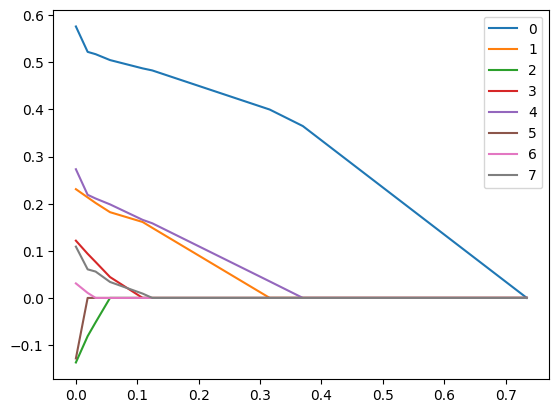

In [8]:
# plot
plt.plot(mod_lars.alphas_,mod_lars.coef_path_.T)
plt.legend(range(8))
plt.show()

Order in which the variables are included in the model:

In [9]:
pd.DataFrame(mod_lars.coef_path_).sort_values(by=np.arange(0,9).tolist(),ascending=False).index.values

array([0, 4, 1, 7, 3, 6, 5, 2])

### b)

In [10]:
mod_lars.alphas_[0]

0.7344603262136732

In [11]:
max_cov=[]
for i in range(8):
    max_cov.append(np.corrcoef(X[:,i],Y)[1,0])
    print(max_cov[-1])

0.7344603262136736
0.4333193824926198
0.16959283918685042
0.17980940394145742
0.5662182224414467
0.5488131747249603
0.3689868062872309
0.4223158578794977


### b1)

In [12]:
selected_variables = list(reversed(np.argsort(max_cov)))
selected_variables

[0, 4, 5, 1, 7, 6, 3, 2]

### b2)

In [13]:
mod1 = LinearRegression(fit_intercept=False)
mod1.fit(X[:,selected_variables[0]].reshape(-1,1),Y)

LinearRegression(fit_intercept=False)

### b3)

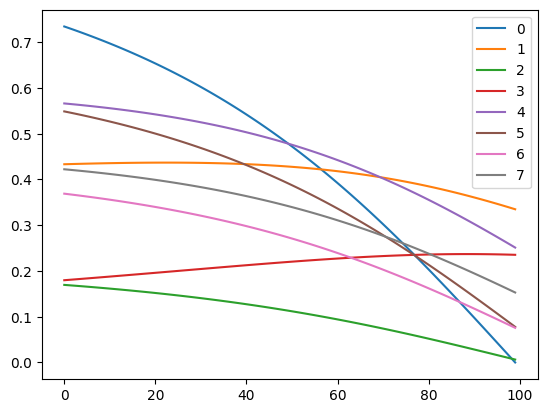

In [14]:
# code 
alphas = np.linspace(0,1,100)
for i in range(8):
    covs=[]
    for alpha in alphas:
        r = Y-alpha*mod1.predict(X[:,selected_variables[0]].reshape(-1,1))
        covs.append(np.corrcoef(X[:,i],r)[1,0])
    plt.plot(covs,label=str(i))
plt.legend()

### b4)

In [16]:
residuals = Y - 0.495 * mod1.predict(X[:,0, np.newaxis]) # 0.495 is the approximated value of alpha
corrs = [np.corrcoef(X[:,i], residuals)[0,1] for i in range(X.shape[1])]
corrs

[0.47957828019458537,
 0.4284156275639239,
 0.11351585681844396,
 0.21963764025459576,
 0.47882112436543606,
 0.3921664092633978,
 0.27382999030472543,
 0.34220401264679773]

In [17]:
np.abs(corrs[0] - corrs[4])

0.0007571558291493141

In [ ]:
s2=4

### b5)

$$ \textrm{Cor}(Y - \tilde\alpha\hat Y, X_i) = ... \cdot\textrm{Cor}(Y, X_i) - ... \cdot \tilde\alpha \cdot \textrm{Cor}(\tilde\alpha\hat Y, X_i) $$

In our case, $i=0$, $j=4$:
$$ |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_i)| = |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_j)|$$

In [18]:
# code
y_hat=mod1.predict(X[:,0, np.newaxis])
var_Y = 1 
var_Y_hat = np.var(y_hat)
corr_Y_X_prev = np.corrcoef(Y, X[:,0])[0,1]
corr_Y_X_new = np.corrcoef(Y, X[:,4])[0,1]
corr_Yhat_X_prev = np.corrcoef(y_hat, X[:,0])[0,1]
corr_Yhat_X_new = np.corrcoef(y_hat, X[:,4])[0,1]
alpha_2_tilde = (np.sqrt(var_Y) * corr_Y_X_prev - np.sqrt(var_Y) * corr_Y_X_new) /  \
         (np.sqrt(var_Y_hat) * corr_Yhat_X_prev - np.sqrt(var_Y_hat) * corr_Yhat_X_new)

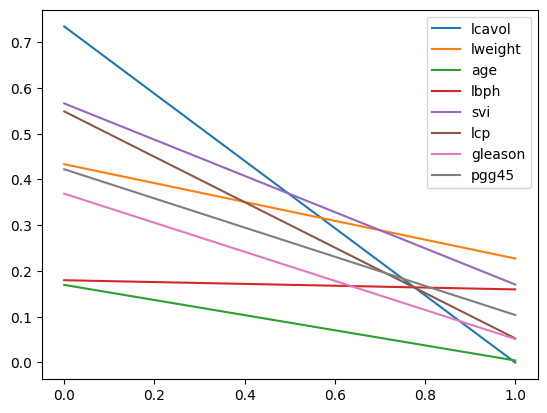

In [19]:
# plot
for i, colname in enumerate(df.columns[0:8]):
    corr_with_Y = np.corrcoef(X[:,i], Y)[0,1]
    corr_with_Yhat = np.corrcoef(X[:,i], y_hat)[0,1]
    plt.plot(alphas, np.sqrt(var_Y) * corr_with_Y - alphas * np.sqrt(var_Y_hat) * corr_with_Yhat, label=colname)
plt.legend()
plt.show()

### b6)

In [20]:
mod_lars.alphas_

array([0.73446033, 0.36963266, 0.3157    , 0.12438766, 0.10869606,
       0.05558212, 0.03210302, 0.01913394, 0.        ])

In [25]:
alpha2 = (np.sqrt(var_Y) * np.corrcoef(Y, X[:, 4]) - alpha_2_tilde * np.sqrt(var_Y_hat) * np.corrcoef(y_hat, X[:, 4]))[0, 1]
alpha2

0.36963265526107475

In [26]:
r1_alpha2 = Y - alpha_2_tilde * y_hat

In [27]:
selected_variables=[0,4]
selected_variables

[0, 4]

### b7)

In [28]:
mod2 = LinearRegression(fit_intercept=False)
mod2.fit(X[:, [0, 4]], r1_alpha2)
mod2.coef_

array([0.24020136, 0.24020136])

### b8)

In [30]:
alphas = np.linspace(0,1,100)
y_hat2 = mod2.predict(X[:, [0, 4]])
res_df = pd.DataFrame()
for i, alpha in enumerate(alphas):
    residuals = r1_alpha2 - alpha * y_hat2
    for j in range(X.shape[1]):
        cor = np.corrcoef(X[:, j], residuals)[0, 1]
        res_df = pd.concat(
            [res_df, pd.DataFrame({"variable": df.columns[j], "correlation": cor, "alpha": alpha}, index=[i])]
        )

<Axes: xlabel='alpha', ylabel='correlation'>

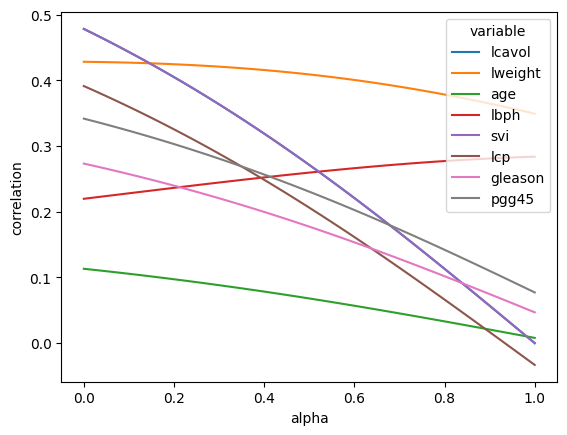

In [38]:
import seaborn as sns
sns.lineplot(res_df,x="alpha", y="correlation", hue="variable")

### b9)

In [39]:
residuals = r1_alpha2 - 0.145 * y_hat2 # 0.145 is the approximated value of alpha_tilde_3
corrs = [np.corrcoef(X[:,i], residuals)[0,1] for i in range(X.shape[1])]
corrs

[0.42636228105572915,
 0.4260374662554156,
 0.10195397210942701,
 0.23186717424623474,
 0.4263622810557296,
 0.3446622863014432,
 0.24959414194646143,
 0.3144256807951182]

In [40]:
np.abs(corrs[0] - corrs[1])

0.00032481480031354426

### b10)

In [41]:
var_Y = np.var(r1_alpha2)
var_Y_hat = np.var(y_hat2)
corr_Y_X_prev = np.corrcoef(r1_alpha2, X[:, 4])[0, 1]
corr_Y_X_new = np.corrcoef(r1_alpha2, X[:, 1])[0, 1]
corr_Yhat_X_prev = np.corrcoef(y_hat2, X[:, 4])[0, 1]
corr_Yhat_X_new = np.corrcoef(y_hat2, X[:, 1])[0, 1]
alpha_3_tilde = (np.sqrt(var_Y) * corr_Y_X_prev - np.sqrt(var_Y) * corr_Y_X_new) / (
    np.sqrt(var_Y_hat) * corr_Yhat_X_prev - np.sqrt(var_Y_hat) * corr_Yhat_X_new
)
alpha_3_tilde

0.14590879649354802

### b11)

### c)

## Task 2

In [ ]:
X = pd.read_table("data/SRBCT_X.txt", sep=" ")
Y = pd.read_table("data/SRBCT_Y.txt", sep=" ")

X = np.array(X)
Y = np.array(Y)[:,0]

In [ ]:
X = scale(X)
Y = Y - np.mean(Y)

### a)

In [ ]:
mod_lars = Lars(n_nonzero_coefs=80)
# fit

In [ ]:
# plot

In [ ]:
# the order

### b)

In [ ]:
mod_lassolars = LassoLars(alpha=0.15)
# fit

In [ ]:
# order

In [ ]:
# plot

### c)

In [ ]:
lasso_coef = np.zeros((X.shape[1], mod_lassolars.alphas_.shape[0]))

In [ ]:
for i in range(mod_lassolars.alphas_.shape[0]):
    mod_lasso = Lasso(alpha=mod_lassolars.alphas_[i])
    mod_lasso.fit(X, Y)

    lasso_coef[:,i] = mod_lasso.coef_

In [ ]:
# plot